# 随机森林实现Titanic幸存者的预测

In [3]:
# 随机模块
import random

# 绘图模块
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px

# numpy&panda
import numpy as np
import pandas as pd

from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier

## 1.数据预览 

In [4]:
train=pd.read_csv('train.csv')
test=pd.read_csv('test.csv')
test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 418 entries, 0 to 417
Data columns (total 11 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  418 non-null    int64  
 1   Pclass       418 non-null    int64  
 2   Name         418 non-null    object 
 3   Sex          418 non-null    object 
 4   Age          332 non-null    float64
 5   SibSp        418 non-null    int64  
 6   Parch        418 non-null    int64  
 7   Ticket       418 non-null    object 
 8   Fare         417 non-null    float64
 9   Cabin        91 non-null     object 
 10  Embarked     418 non-null    object 
dtypes: float64(2), int64(4), object(5)
memory usage: 36.0+ KB


In [5]:
corr = train.corr()
corr.style.background_gradient(cmap='coolwarm')

,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare
PassengerId,1.000000,-0.005007,-0.035144,0.036847,-0.057527,-0.001652,0.012658
Survived,-0.005007,1.000000,-0.338481,-0.077221,-0.035322,0.081629,0.257307
Pclass,-0.035144,-0.338481,1.000000,-0.369226,0.083081,0.018443,-0.549500
Age,0.036847,-0.077221,-0.369226,1.000000,-0.308247,-0.189119,0.096067
SibSp,-0.057527,-0.035322,0.083081,-0.308247,1.000000,0.414838,0.159651
Parch,-0.001652,0.081629,0.018443,-0.189119,0.414838,1.000000,0.216225
Fare,0.012658,0.257307,-0.549500,0.096067,0.159651,0.216225,1.000000


D:\Anaconda3\envs\sklearn\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


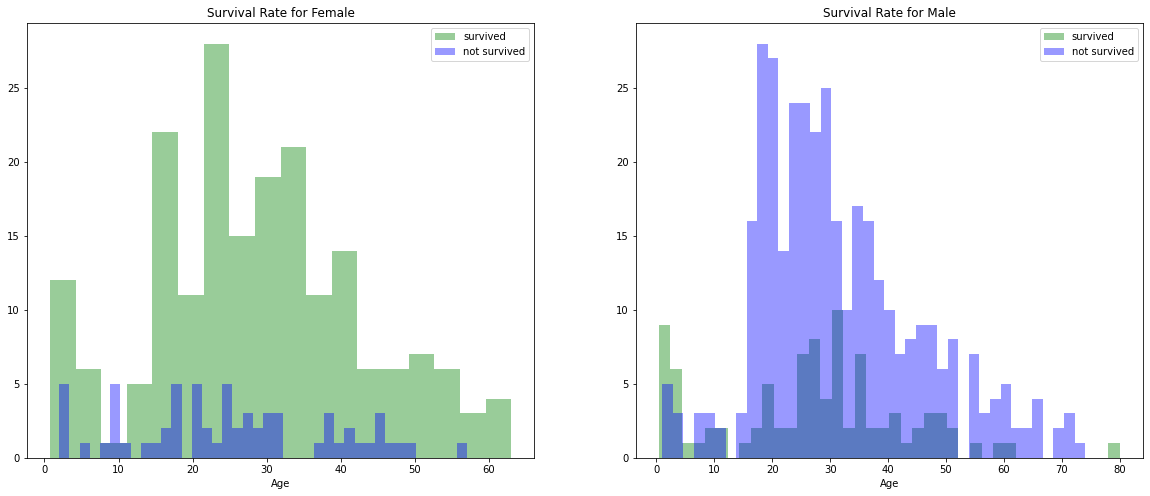

In [37]:
survived = 'survived'
not_survived = 'not survived'
fig, axes = plt.subplots(nrows=1, ncols=2,figsize=(20, 8))
women = train[train['Sex']=='female']
men = train[train['Sex']=='male']

a = sns.distplot(women[women['Survived']==1].Age.dropna(), bins=18, label = survived, ax = axes[0], kde =False, color="green")
a = sns.distplot(women[women['Survived']==0].Age.dropna(), bins=40, label = not_survived, ax = axes[0], kde =False, color="blue")
a.legend()
a.set_title('Survival Rate for Female')

b = sns.distplot(men[men['Survived']==1].Age.dropna(), bins=40, label = survived, ax = axes[1], kde = False, color="green")
b = sns.distplot(men[men['Survived']==0].Age.dropna(), bins=40, label = not_survived, ax = axes[1], kde = False, color="blue")
b.legend()
b = b.set_title('Survival Rate for Male');

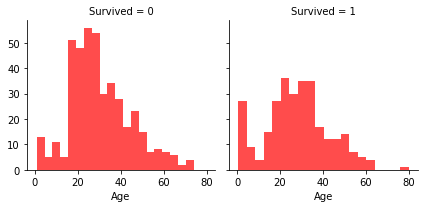

In [38]:
g = sns.FacetGrid(train, col='Survived')
g.map(plt.hist, 'Age', bins=20,color='red', alpha=.7)

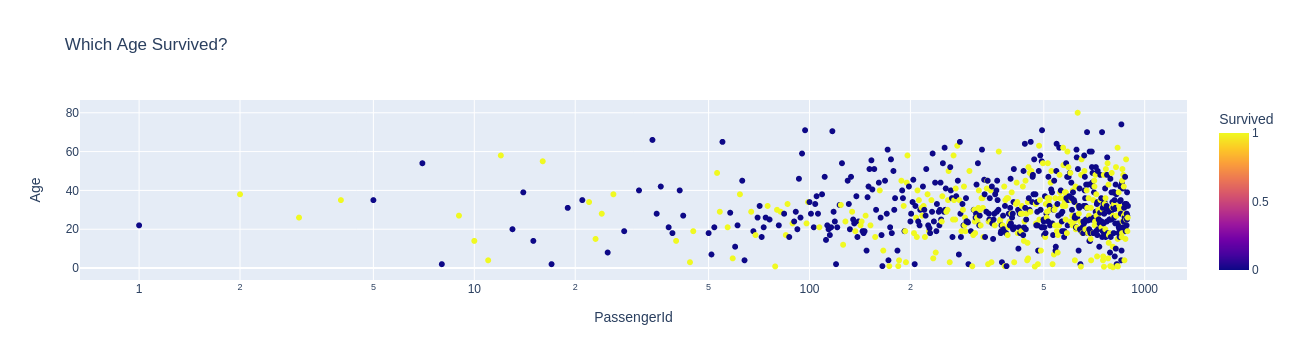

In [44]:
for template in ["plotly"]:
    fig = px.scatter(train,
                     x="PassengerId", y="Age", color="Survived",
                     log_x=True, size_max=20,
                     template=template, title="Which Age Survived?")
    fig.show()

## 2.特征工程

### 2.1将连续性变量转为离散数据

In [164]:
train['Age&Sex_S'] = train.apply(lambda x: 1 if (x['Sex'] == 'female' and x['Age'] <= 16 ) or (x['Sex'] == 'male') else 0,axis = 1)
train['Relatives'] = train.apply(lambda x: 0 if x['SibSp'] == 0 and x['Parch'] == 0 else 1,axis = 1)
test['Age&Sex_S'] = test.apply(lambda x: 1 if (x['Sex'] == 'female' and x['Age'] <= 16 ) or (x['Sex'] == 'male') else 0,axis = 1)
test['Relatives'] = test.apply(lambda x: 0 if x['SibSp'] == 0 and x['Parch'] == 0 else 1,axis = 1)

### 2.2转换非数值型变量

In [165]:
labels = train["Embarked"].unique().tolist()
train["Embarked"] = train["Embarked"].apply(lambda x: labels.index(x))
test["Embarked"] = test["Embarked"].apply(lambda x: labels.index(x))

In [166]:
corr = train.corr()
corr.style.background_gradient(cmap='coolwarm')

,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare,Embarked,Age&Sex_S,Relatives
PassengerId,1.000000,-0.005007,-0.035144,0.036847,-0.057527,-0.001652,0.012658,-0.029906,0.027253,-0.057462
Survived,-0.005007,1.000000,-0.338481,-0.077221,-0.035322,0.081629,0.257307,0.118026,-0.496188,0.203367
Pclass,-0.035144,-0.338481,1.000000,-0.369226,0.083081,0.018443,-0.549500,0.028566,0.172741,-0.135207
Age,0.036847,-0.077221,-0.369226,1.000000,-0.308247,-0.189119,0.096067,0.031556,-0.123276,-0.198270
SibSp,-0.057527,-0.035322,0.083081,-0.308247,1.000000,0.414838,0.159651,-0.063794,-0.043224,0.584471
Parch,-0.001652,0.081629,0.018443,-0.189119,0.414838,1.000000,0.216225,-0.082144,-0.145915,0.583398
Fare,0.012658,0.257307,-0.549500,0.096067,0.159651,0.216225,1.000000,0.071010,-0.189845,0.271832
Embarked,-0.029906,0.118026,0.028566,0.031556,-0.063794,-0.082144,0.071010,1.000000,-0.126876,-0.025927
Age&Sex_S,0.027253,-0.496188,0.172741,-0.123276,-0.043224,-0.145915,-0.189845,-0.126876,1.000000,-0.209295
Relatives,-0.057462,0.203367,-0.135207,-0.198270,0.584471,0.583398,0.271832,-0.025927,-0.209295,1.000000


### 2.3删除一些不需要的特征

In [167]:
train.drop(['PassengerId','Fare','Name','Ticket','Cabin','SibSp','Parch','Age','Sex'],axis = 1,inplace = True)
test.drop(['PassengerId','Fare','Name','Ticket','Cabin','SibSp','Parch','Age','Sex'],axis = 1,inplace = True)
test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 418 entries, 0 to 417
Data columns (total 4 columns):
 #   Column     Non-Null Count  Dtype
---  ------     --------------  -----
 0   Pclass     418 non-null    int64
 1   Embarked   418 non-null    int64
 2   Age&Sex_S  418 non-null    int64
 3   Relatives  418 non-null    int64
dtypes: int64(4)
memory usage: 13.2 KB


### 2.4分离特征和标签

In [170]:
X_train=train.iloc[:,1:]
Y_train=train.iloc[:,:1]
X_test=test

X_test

,Pclass,Embarked,Age&Sex_S,Relatives
0,3,2,1,0
1,3,0,0,1
2,2,2,1,0
3,3,0,1,0
4,3,0,0,1
...,...,...,...,...
413,3,0,1,0
414,1,1,0,0
415,3,0,1,0
416,3,0,1,0


# 3.建立模型

In [171]:
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import cross_val_score
import warnings
warnings.filterwarnings("ignore")

### 3.1简单测试准确率 

In [172]:
clf = RandomForestClassifier(random_state=25)
clf = clf.fit(X_train, Y_train)
score = clf.score(X_train, Y_train)
score


0.7912457912457912

### 3.2找到最好的n_estimators

In [ ]:
scorel = []
for i in range(0,200,10):
    rfc = RandomForestClassifier(n_estimators=i+1,
                            n_jobs=-1,random_state=25)
    score = cross_val_score(rfc,X_train,Y_train,cv=10).mean()
    scorel.append(score)
print(max(scorel),(scorel.index(max(scorel))*10)+1)
plt.figure(figsize=[20,5])
plt.plot(range(1,201,10),scorel)
plt.show()

In [ ]:
scorel = []
for i in range(130,150,1):
    rfc = RandomForestClassifier(n_estimators=i+1,
                            n_jobs=-1,random_state=25)
    score = cross_val_score(rfc,X_train,Y_train,cv=10).mean()
    scorel.append(score)
print(max(scorel),(scorel.index(max(scorel))*10)+1)
plt.figure(figsize=[20,5])
plt.plot(range(1,201,10),scorel)
plt.show()

In [173]:
rfc = RandomForestClassifier(n_estimators=81,
                            n_jobs=-1,random_state=25)
rfc=rfc.fit(X_train,Y_train)
Y_predict=rfc.predict(X_test)
Y_predict

array([0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 1, 0, 1, 1, 0, 0, 0, 1, 1, 0,
       1, 1, 1, 0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 1,
       1, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 1,
       1, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 1, 0, 1, 1, 0, 0, 0, 0, 1, 1, 0,
       1, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0,
       0, 1, 1, 1, 1, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0,
       0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0,
       0, 0, 1, 0, 0, 0, 1, 1, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0,
       1, 1, 1, 1, 0, 1, 1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0,
       0, 0, 1, 0, 1, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0,
       1, 0, 1, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0, 1, 1, 1, 1,
       1, 0, 0, 0, 1, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 1, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0,
       0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0,

In [174]:
submission = pd.read_csv('gender_submission.csv')
output = pd.DataFrame({'PassengerId': submission.PassengerId, 'Survived': Y_predict})
output.to_csv("submission.csv", index = False)